<a href="https://colab.research.google.com/github/sdave-connexion/Hierarical-sales-forecsting/blob/main/13sept_univariate_timeseries_using_prophet_hyperparameter_tuning_ID2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monthly Time Series forecasting using Facebook's Prophet for Brand ID 2


Goal is to do timeseries analysis and predict next 12 months sales using Facebook Prophet 

In [ ]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm
# prophet by Facebook
from prophet import Prophet
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

### Read the dataset

In [ ]:
df = pd.read_csv("/content/id2_raw.csv",parse_dates=[0])

### Head & Tail of the dataframe

In [ ]:
print('-'*60)
print('*** Head of the dataframe ***')
print('-'*60)
print(df.head())
print('-'*60)
print('*** Tail of the dataframe ***')
print('-'*60)
print(df.tail())

------------------------------------------------------------
*** Head of the dataframe ***
------------------------------------------------------------
        Date  Sales
0 2019-01-01  21505
1 2019-02-01  19438
2 2019-03-01  21423
3 2019-04-01  19049
4 2019-05-01  19604
------------------------------------------------------------
*** Tail of the dataframe ***
------------------------------------------------------------
         Date  Sales
31 2021-08-01  34319
32 2021-09-01  33420
33 2021-10-01  38221
34 2021-11-01  40110
35 2021-12-01  35656


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    36 non-null     datetime64[ns]
 1   Sales   36 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 704.0 bytes


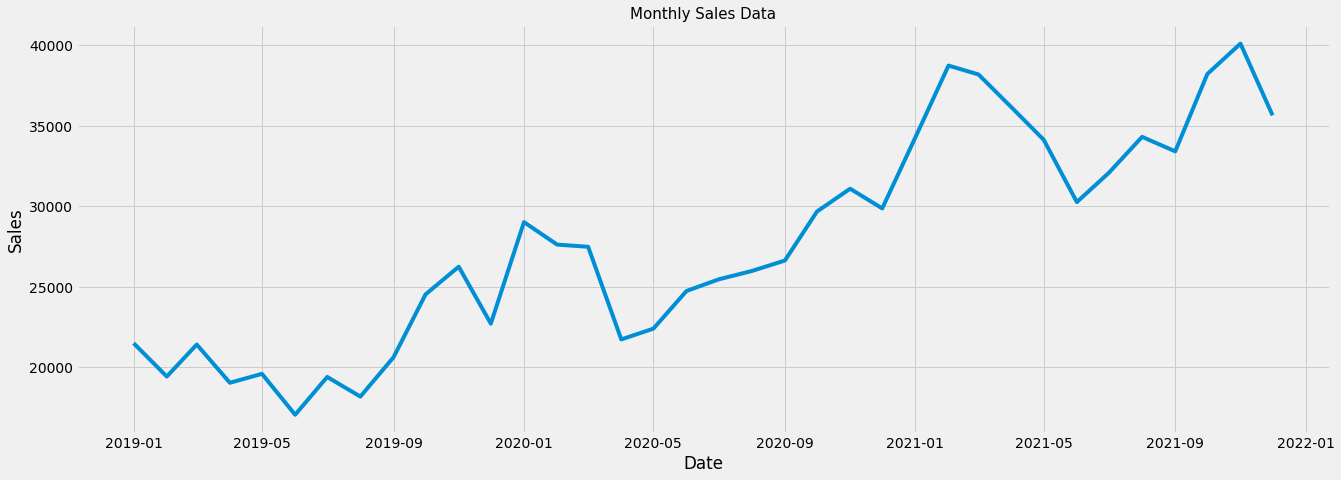

In [ ]:
## Plot the Time series data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="Date", y="Sales", data=df)
a.set_title("Monthly Sales Data",fontsize=15)
plt.show()

# Exploratory Data Analysis

Creates time series features from Date column.

In [ ]:
def date_features(df, label=None):
    df = df.copy()
    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['quarter'] = df['date'].dt.quarter
    X = df[['date','quarter','month','year']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(df, label='Sales')
df_new = pd.concat([X, y], axis=1)
df_new.head()

,date,quarter,month,year,Sales
0,2019-01-01,1,January,2019,21505
1,2019-02-01,1,February,2019,19438
2,2019-03-01,1,March,2019,21423
3,2019-04-01,2,April,2019,19049
4,2019-05-01,2,May,2019,19604


## Plotting the Features to see trends
* Sales has strong monthly and seasonal properties.
* 2nd and 3rd quarter/ summer season also seems to show differences in peaks

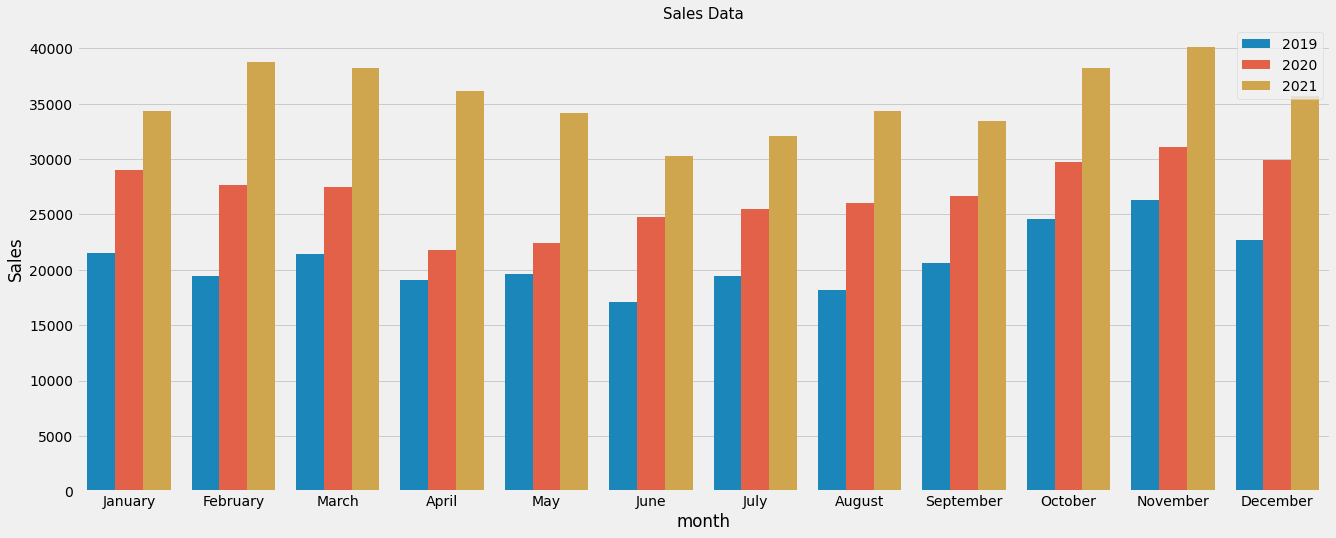

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
palette = sns.color_palette("mako_r", 3)
a = sns.barplot(x="month", y="Sales",hue = 'year',data=df_new)
a.set_title("Sales Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Total Sales received By year')

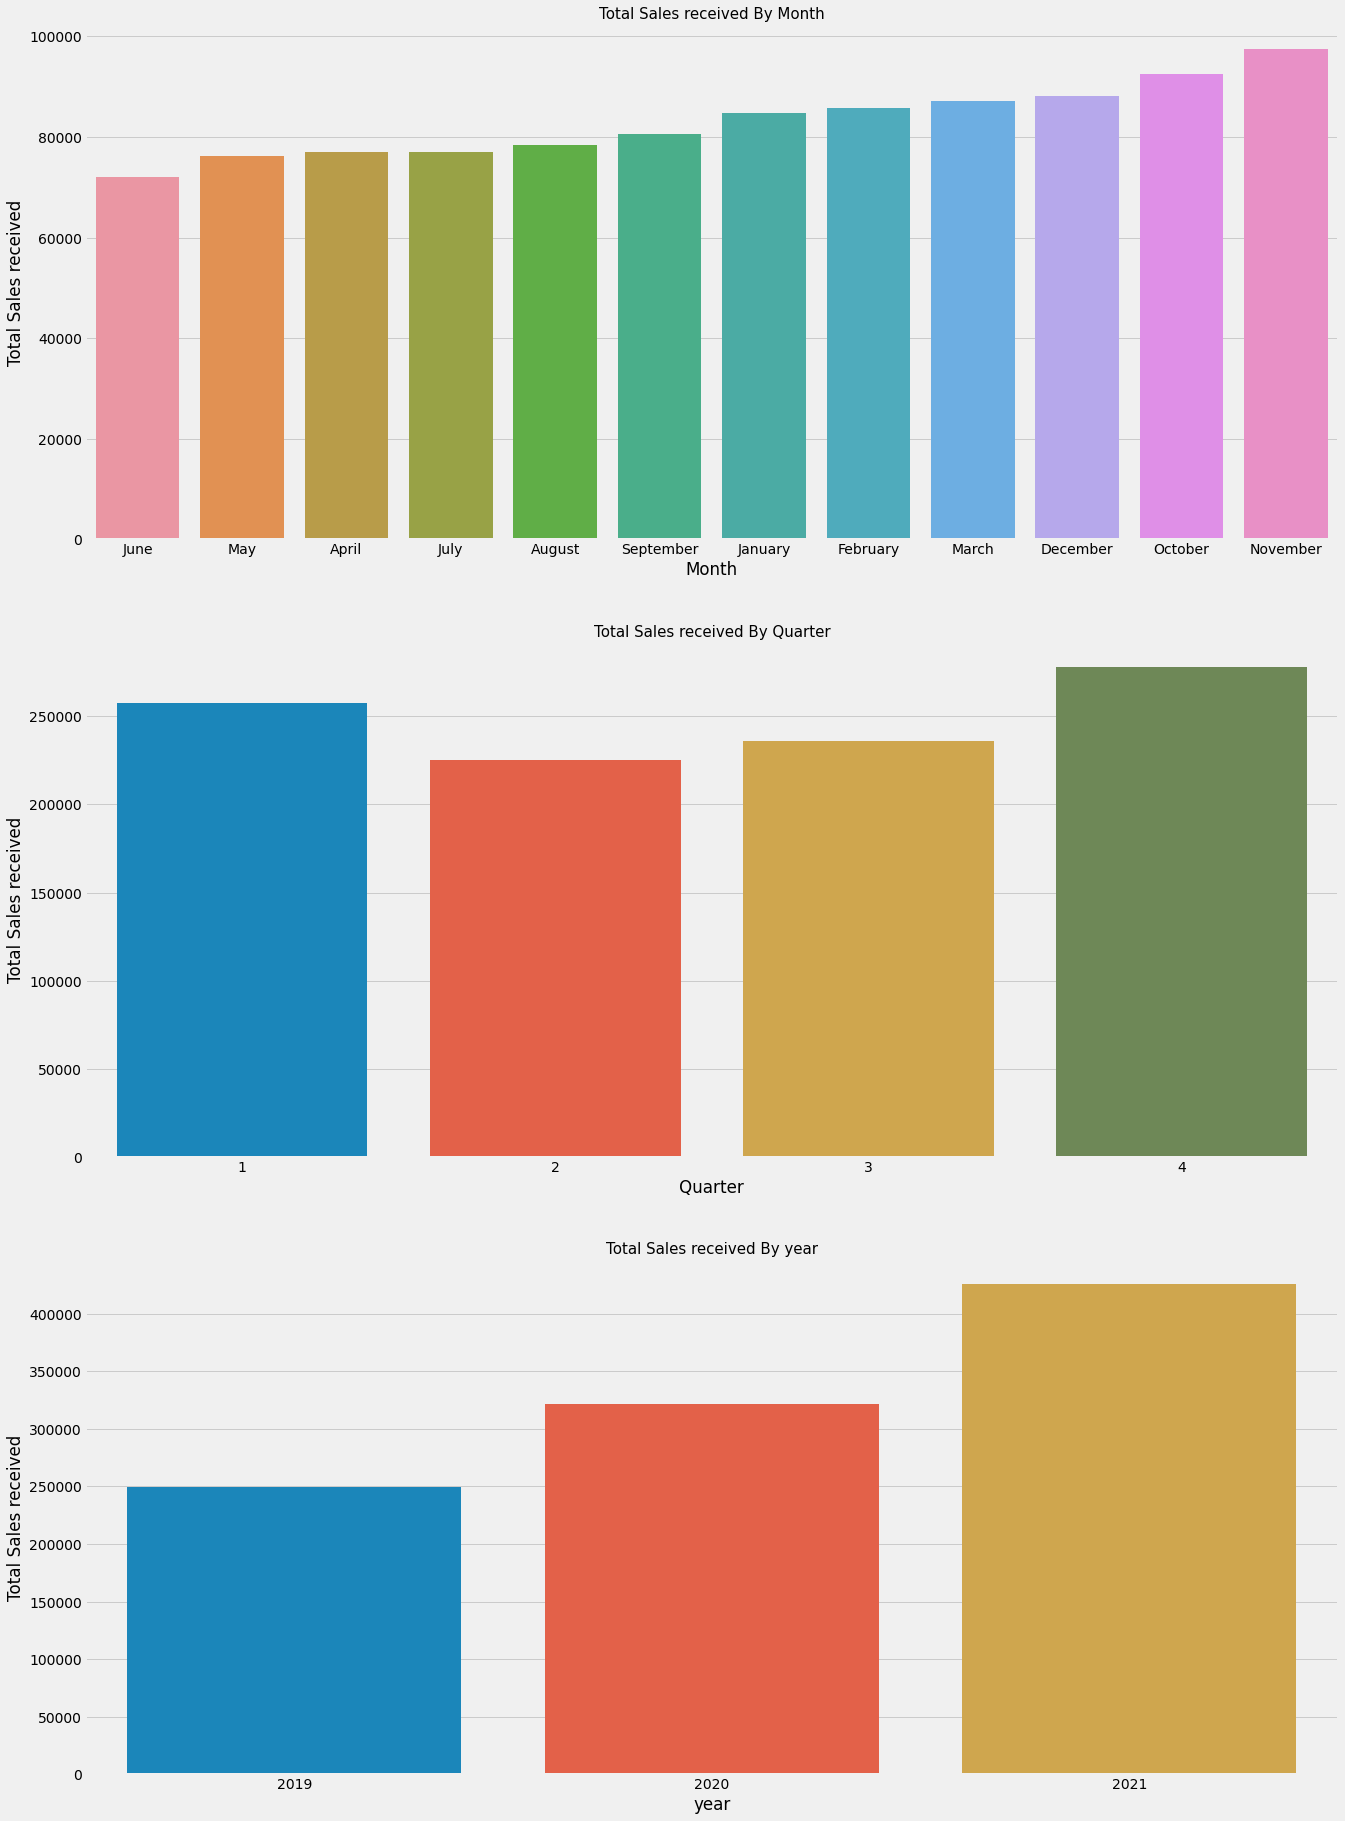

In [ ]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="month",y="Sales",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales received')
ax1.set_title("Total Sales received By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="quarter",y="Sales",ax=ax2)
ax2.set(xlabel='Quarter', ylabel='Total Sales received')
ax2.set_title("Total Sales received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="year",y="Sales",ax=ax3)
ax3.set(xlabel='year', ylabel='Total Sales received')
ax3.set_title("Total Sales received By year",fontsize=15)

In [ ]:
df=df.rename(columns={'Date':'ds','Sales':'y'})
df.head()

,ds,y
0,2019-01-01,21505
1,2019-02-01,19438
2,2019-03-01,21423
3,2019-04-01,19049
4,2019-05-01,19604


Dividing the dataset into train and test. The train has data from Jan,2019 to to Dec,2020. Test Data has 12 months from Jan,2021 to Dec 2021.

In [ ]:
end_date = '2020-12-31'
mask1 = (df['ds'] <= end_date)
mask2 = (df['ds'] > end_date)

In [ ]:
X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (24, 2)
test shape (12, 2)


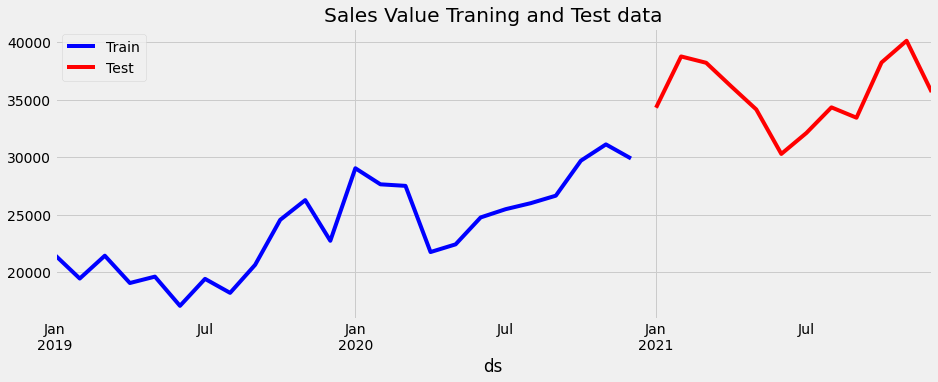

In [ ]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Sales Value Traning and Test data')
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Simple Prophet Model

In [ ]:
model =Prophet()
model.fit(X_tr)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/ek43skq1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/bnwreihe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72899', 'data', 'file=/tmp/tmp_a52dkt0/ek43skq1.json', 'init=/tmp/tmp_a52dkt0/bnwreihe.json', 'output', 'file=/tmp/tmp1ip69d03/prophet_model-20220912230533.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:05:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1]

Now, we will predict by creating future dataframe next dates of train data. make_future_dataframe has include_history = True by default. So the predcition will be done for train data as well.

In [ ]:
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
24,2021-01-01,29584.965503,26449.530465,32648.040767
25,2021-02-01,30053.430044,26918.286922,33419.696495
26,2021-03-01,30476.559307,27421.219864,33494.489523
27,2021-04-01,30945.023847,27723.427786,34011.282625
28,2021-05-01,31398.376629,28276.811513,34217.952355
29,2021-06-01,31866.841170,28924.576222,35054.147107
30,2021-07-01,32320.193951,29129.275728,35193.957310
31,2021-08-01,32788.658492,29585.307306,36052.824277
32,2021-09-01,33257.123032,30218.043758,36305.916984
33,2021-10-01,33710.475814,30372.393710,36980.715099


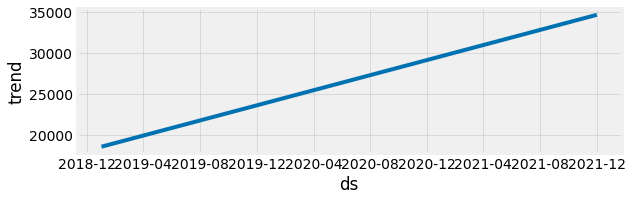

In [ ]:
# Plot the components of the model
fig = model.plot_components(forecast)

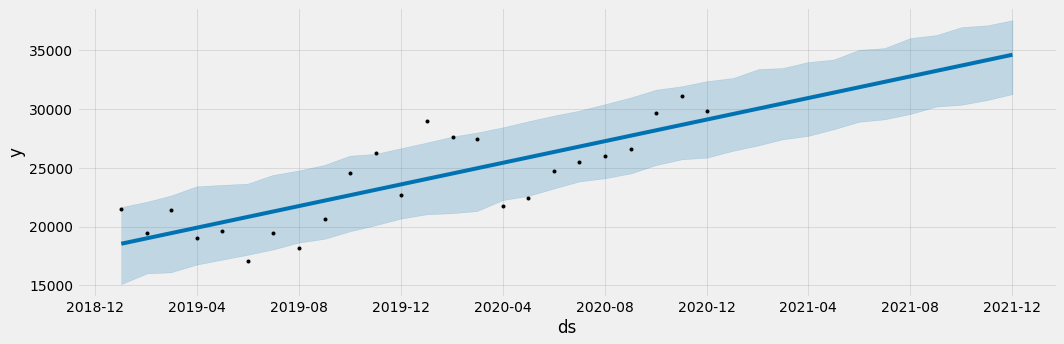

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

## Actual vs Prediction Comparison

In [ ]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
5,2021-06-01,31866.841170,28613.621292,35011.097688
6,2021-07-01,32320.193951,29085.973974,35102.897288
7,2021-08-01,32788.658492,29834.757912,35861.188792
8,2021-09-01,33257.123032,30024.798844,36539.524846
9,2021-10-01,33710.475814,30544.302669,36896.190533
10,2021-11-01,34178.940354,31384.140008,37221.714569
11,2021-12-01,34632.293136,31458.307344,37931.754202


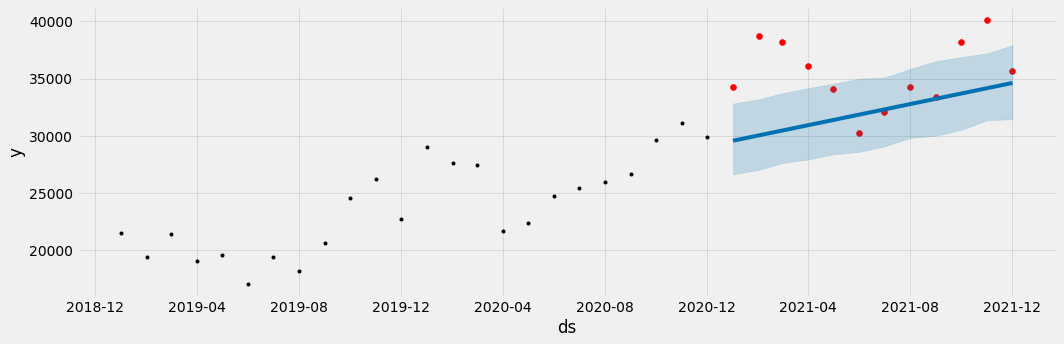

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

### Compare the test Sales and forecasted Sales

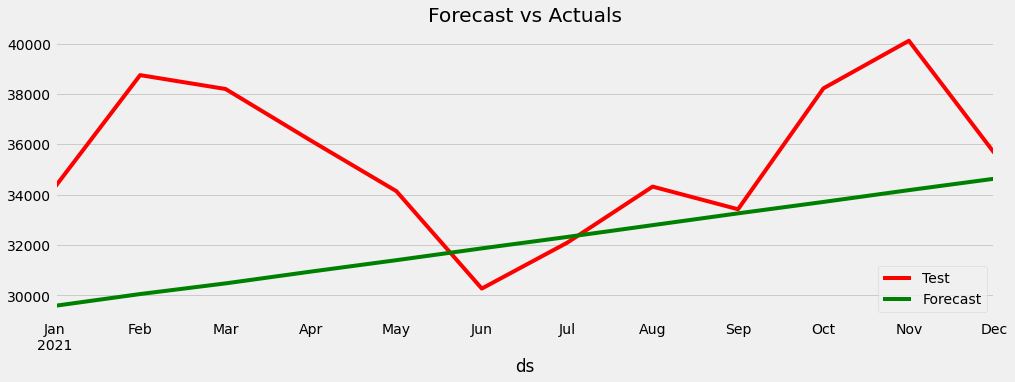

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

We can see from the above plot, that there is huge gap in prediction. So we need to optimize the model by adding other parameters like holidays, changepoints etc.

In [ ]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 9.9304


### Adding Holidays to the model
We will use **holidays** library to get the DE holidays

In [ ]:
import holidays

In [ ]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Germany(years=[2019,2020,2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "de-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
holiday.head()

,ds,holiday
0,2019-01-01,de-Holidays
1,2019-04-19,de-Holidays
2,2019-04-22,de-Holidays
3,2019-05-01,de-Holidays
4,2019-05-30,de-Holidays


In [ ]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(X_tr)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/0i4joe5w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/w257uezm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96254', 'data', 'file=/tmp/tmp_a52dkt0/0i4joe5w.json', 'init=/tmp/tmp_a52dkt0/w257uezm.json', 'output', 'file=/tmp/tmpxaje0g61/prophet_model-20220912230625.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:06:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1]

In [ ]:
future = model_with_holidays.make_future_dataframe(periods=12, freq='MS')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
24,2021-01-01,30075.815593,27040.664306,33244.621081
25,2021-02-01,30006.568118,26801.850248,33001.713807
26,2021-03-01,30434.123391,27524.238639,33530.811787
27,2021-04-01,30907.488158,27641.226746,33984.956695
28,2021-05-01,31908.195336,28630.268432,34919.433018
29,2021-06-01,31838.947861,28670.477314,35082.469358
30,2021-07-01,32297.042796,29246.839284,35358.531271
31,2021-08-01,32770.407563,29759.792411,35938.715760
32,2021-09-01,33243.772330,30265.695717,36230.741775
33,2021-10-01,33701.867266,30539.383728,36637.489590


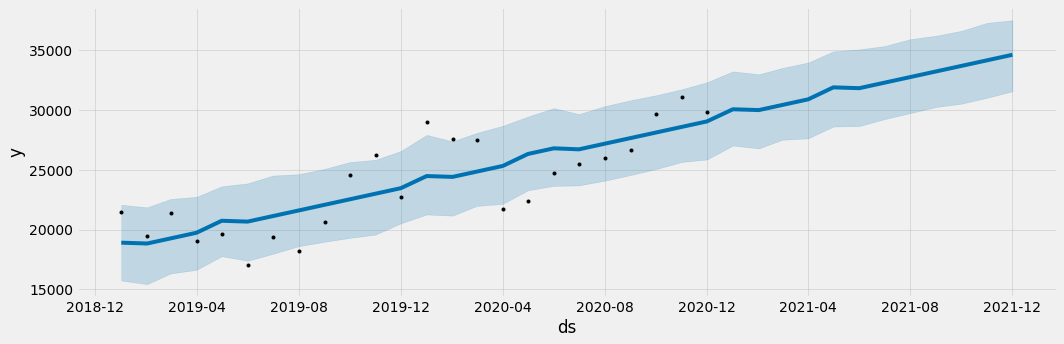

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

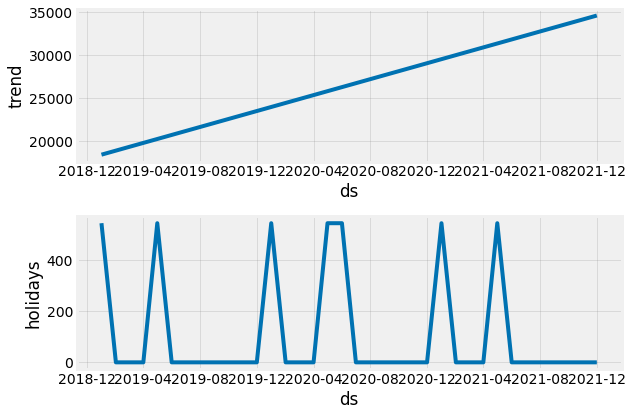

In [ ]:
# Plot the components of the model
fig = model_with_holidays.plot_components(forecast)

In [ ]:
X_tst_forecast_holiday = model_with_holidays.predict(X_tst)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
0,2021-01-01,30075.815593,27034.025405,33146.288140
1,2021-02-01,30006.568118,27302.235442,32928.831537
2,2021-03-01,30434.123391,27175.642773,33507.030634
3,2021-04-01,30907.488158,27645.457490,33962.403830
4,2021-05-01,31908.195336,28874.368036,35091.355475
5,2021-06-01,31838.947861,28717.338562,35201.822169
6,2021-07-01,32297.042796,29234.729428,35495.116948
7,2021-08-01,32770.407563,29604.381181,35702.543295
8,2021-09-01,33243.772330,30239.181935,36292.567927
9,2021-10-01,33701.867266,30531.824172,36720.348831


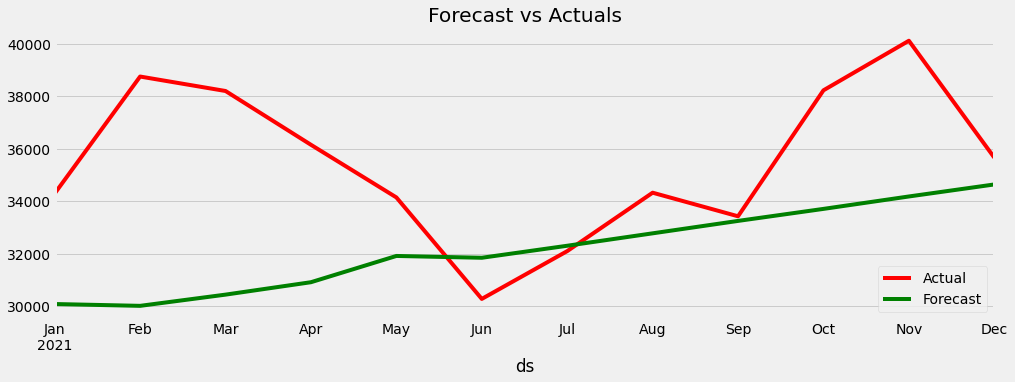

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast_holiday['yhat'])
print("MAPE",round(mape,4))

MAPE 9.7111


From the above results, we can see that by adding holidays in the model, model performance does not improve much. We need to add other parameters to tune the model.

# HyperParameter Tuning using ParameterGrid

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2],
              'holidays_prior_scale':[0.1,0.2],
              'n_changepoints' : [12]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 8


In [ ]:
X_tr

,ds,y
0,2019-01-01,21505
1,2019-02-01,19438
2,2019-03-01,21423
3,2019-04-01,19049
4,2019-05-01,19604
5,2019-06-01,17064
6,2019-07-01,19410
7,2019-08-01,18192
8,2019-09-01,20632
9,2019-10-01,24541


# Prophet Model Tuning

In [ ]:
strt='2020-12-01'
end='2021-12-01'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         #weekly_seasonality=True,
                         #daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='DE')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=12, freq='MS',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/vbc3_vfr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/656txoyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23920', 'data', 'file=/tmp/tmp_a52dkt0/vbc3_vfr.json', 'init=/tmp/tmp_a52dkt0/656txoyo.json', 'output', 'file=/tmp/tmp6lvkizuv/prophet_model-20220912230849.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


23:09:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/x6cja70p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/rhic70rn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40739', 'data', 'file=/tmp/tmp_a52dkt0/x6cja70p.json', 'init=/tmp/tmp_a52dkt0/rhic70rn.json', 'output', 'file=/tmp/tmppnhbdm1i/prophet_model-20220912230902.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:09:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.32577691609677
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


23:09:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/7025oisr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/7t_yl2af.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42505', 'data', 'file=/tmp/tmp_a52dkt0/7025oisr.json', 'init=/tmp/tmp_a52dkt0/7t_yl2af.json', 'output', 'file=/tmp/tmpr1d8y05d/prophet_model-20220912230914.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:09:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.579095004043682
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


23:09:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/ceh1mfxt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/7j9kqpkb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62511', 'data', 'file=/tmp/tmp_a52dkt0/ceh1mfxt.json', 'init=/tmp/tmp_a52dkt0/7j9kqpkb.json', 'output', 'file=/tmp/tmphi1755am/prophet_model-20220912230927.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:09:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.104597631944719
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


23:09:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/jw2wc3q6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/g_tcdcdb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57844', 'data', 'file=/tmp/tmp_a52dkt0/jw2wc3q6.json', 'init=/tmp/tmp_a52dkt0/g_tcdcdb.json', 'output', 'file=/tmp/tmpo8fq4jlx/prophet_model-20220912230939.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:09:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 9.312495545407316
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


23:09:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/dxqd6lyw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/nsp436gv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83026', 'data', 'file=/tmp/tmp_a52dkt0/dxqd6lyw.json', 'init=/tmp/tmp_a52dkt0/nsp436gv.json', 'output', 'file=/tmp/tmplra4gpud/prophet_model-20220912230952.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:09:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.732242536513608
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


23:10:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/mqpuj963.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/vaaxc6er.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85256', 'data', 'file=/tmp/tmp_a52dkt0/mqpuj963.json', 'init=/tmp/tmp_a52dkt0/vaaxc6er.json', 'output', 'file=/tmp/tmp0v2pn_0m/prophet_model-20220912231005.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:10:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 7.943800810077235
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'multiplicative'}


23:10:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/xammtvhw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/9zmx4b2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70250', 'data', 'file=/tmp/tmp_a52dkt0/xammtvhw.json', 'init=/tmp/tmp_a52dkt0/9zmx4b2k.json', 'output', 'file=/tmp/tmps1m22xja/prophet_model-20220912231017.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:10:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 10.497535557183102
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 12, 'seasonality_mode': 'additive'}


23:10:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 8.75931681601556


In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head(9)

,MAPE,Parameters
0,7.943801,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
1,8.579095,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
2,8.759317,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
3,9.312496,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
4,10.104598,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
5,10.325777,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
6,10.497536,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
7,10.732243,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."


Out of total 8 models, we will select the parameters which has the least MAPE to train the final model and predict the next 12 months sales of the store.

Best Parameters on which the model has the least MAPE is:

In [ ]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.2,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 12,
 'seasonality_mode': 'additive'}

In [ ]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.2,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 12,
                      seasonality_mode = 'additive',
                      #weekly_seasonality=True,
                      #daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='DE')
final_model.fit(X_tr)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/3w9y0dct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/w38crws1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74345', 'data', 'file=/tmp/tmp_a52dkt0/3w9y0dct.json', 'init=/tmp/tmp_a52dkt0/w38crws1.json', 'output', 'file=/tmp/tmpkybp3ikz/prophet_model-20220912231151.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:11:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:12:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = final_model.make_future_dataframe(periods=12, freq='MS')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
24,2021-01-01,43521.267992,43057.458627,43989.270303
25,2021-02-01,37095.136041,35663.687307,38343.064574
26,2021-03-01,35698.183422,33374.554246,37778.868669
27,2021-04-01,30332.711872,26731.668582,33428.213007
28,2021-05-01,30584.889597,25815.362208,34612.293241
29,2021-06-01,34360.474175,28341.515072,40028.063177
30,2021-07-01,32655.752372,25091.509630,39799.350228
31,2021-08-01,32677.812212,23350.487940,41391.504465
32,2021-09-01,33997.350875,22950.896045,44385.363647
33,2021-10-01,37396.309778,24308.054403,49443.413053


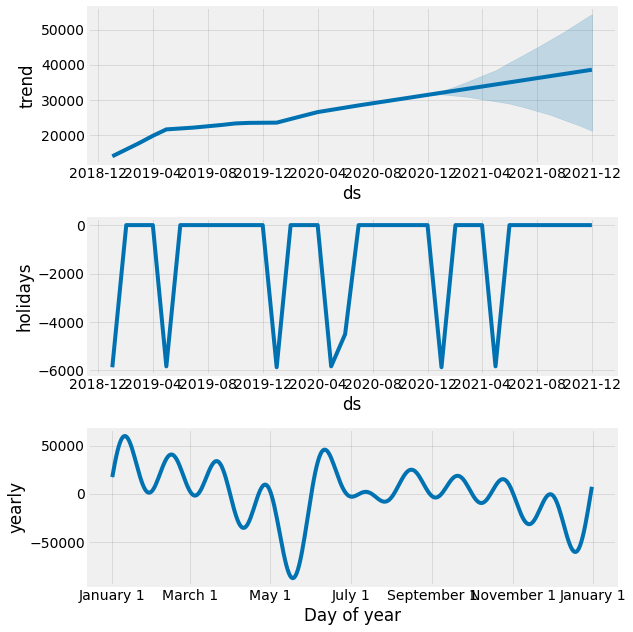

In [ ]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

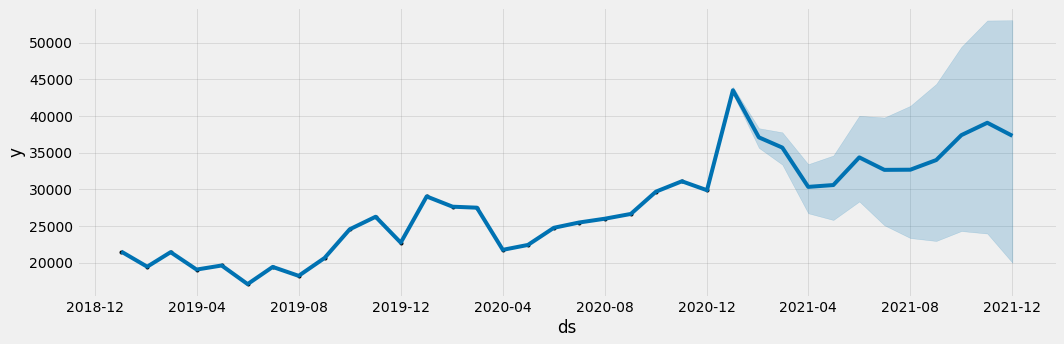

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [ ]:
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
5,2021-06-01,34360.474175,28100.594573,40053.930468
6,2021-07-01,32655.752372,24955.035434,39951.689055
7,2021-08-01,32677.812212,23578.771436,41564.760562
8,2021-09-01,33997.350875,23322.161218,44727.173831
9,2021-10-01,37396.309778,25039.059060,49972.916773
10,2021-11-01,39084.473647,25173.995308,53829.255457
11,2021-12-01,37303.803834,21881.948773,54544.985363


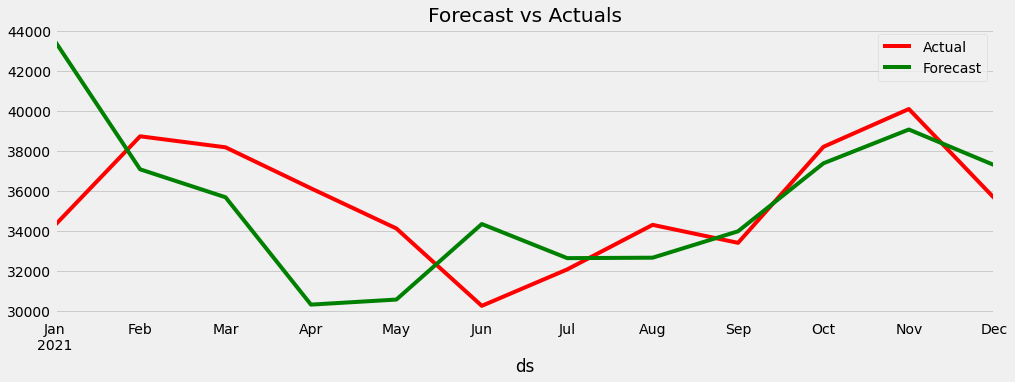

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [ ]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)


MAPE 7.943800810077235


In [ ]:
from pandasql import sqldf
mysql = lambda q: sqldf(q, globals()) 
query = ''' select X_tst.ds , X_tst.y , X_tst_final.yhat , ABS((yhat-y)/yhat)*100 as diff
from X_tst
inner join X_tst_final on X_tst.ds=X_tst_final.ds
group by X_tst.ds''' 
mysql(query)

,ds,y,yhat,diff
0,2021-01-01 00:00:00.000000,34289,43521.267992,21.213233
1,2021-02-01 00:00:00.000000,38746,37095.136041,4.450352
2,2021-03-01 00:00:00.000000,38195,35698.183422,6.994240
3,2021-04-01 00:00:00.000000,36145,30332.711872,19.161782
4,2021-05-01 00:00:00.000000,34139,30584.889597,11.620478
5,2021-06-01 00:00:00.000000,30271,34360.474175,11.901681
6,2021-07-01 00:00:00.000000,32092,32655.752372,1.726349
7,2021-08-01 00:00:00.000000,34319,32677.812212,5.022331
8,2021-09-01 00:00:00.000000,33420,33997.350875,1.698223
9,2021-10-01 00:00:00.000000,38221,37396.309778,2.205272


In [ ]:
# Setup and train model with holidays
final_model_1 = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 24,
                      seasonality_mode = 'additive',
                      #weekly_seasonality=True,
                      #daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model_1.add_country_holidays(country_name='DE')
final_model_1.fit(X_tr)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/5ryo0uws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_a52dkt0/hd8lsb0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5365', 'data', 'file=/tmp/tmp_a52dkt0/5ryo0uws.json', 'init=/tmp/tmp_a52dkt0/hd8lsb0g.json', 'output', 'file=/tmp/tmpyq5v5ws2/prophet_model-20220912231327.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:13:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:13:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done

In [ ]:
future_1 = final_model_1.make_future_dataframe(periods=12, freq='MS')
forecast_1 = final_model_1.predict(future_1)
forecast_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
24,2021-01-01,43119.508871,42849.217448,43413.509705
25,2021-02-01,38195.147402,37477.445204,38995.960676
26,2021-03-01,36994.224764,35655.596194,38441.379090
27,2021-04-01,32478.121698,30492.580402,34727.918958
28,2021-05-01,33108.459420,30212.112534,36118.996607
29,2021-06-01,38830.607615,35106.634611,42816.674149
30,2021-07-01,34571.661128,29890.836586,39513.366272
31,2021-08-01,34612.667808,28905.138867,40765.779844
32,2021-09-01,35957.647777,29243.905396,43328.433512
33,2021-10-01,39286.500929,31433.402543,47852.377905


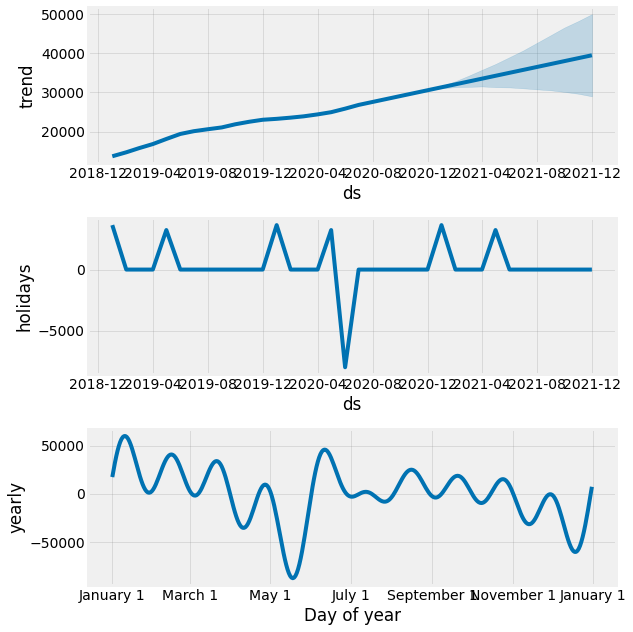

In [ ]:
# Plot the components of the model
fig = final_model.plot_components(forecast_1)

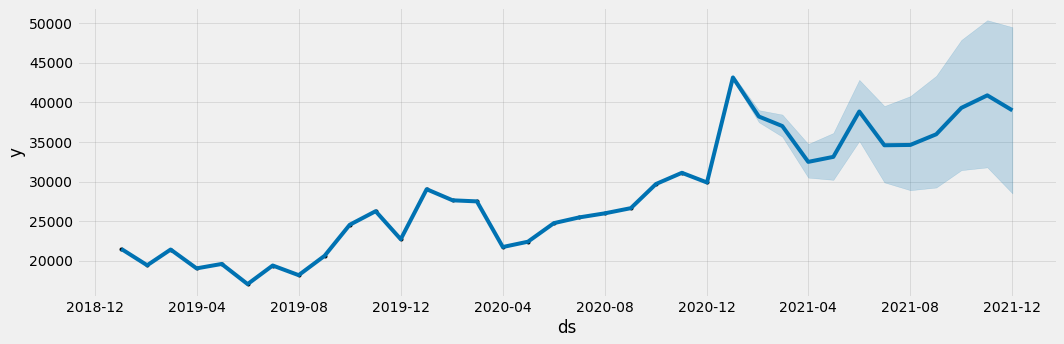

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast_1,ax=ax)
plt.show()

In [ ]:
X_tst_final_1= final_model_1.predict(X_tst)
X_tst_final_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
5,2021-06-01,38830.607615,34608.171686,43119.823714
6,2021-07-01,34571.661128,29398.157343,39899.355230
7,2021-08-01,34612.667808,28298.736647,41098.939387
8,2021-09-01,35957.647777,28394.988865,43707.490693
9,2021-10-01,39286.500929,30255.959732,48233.406252
10,2021-11-01,40865.646296,30594.909278,51307.549837
11,2021-12-01,38971.543163,27356.632558,50627.981735


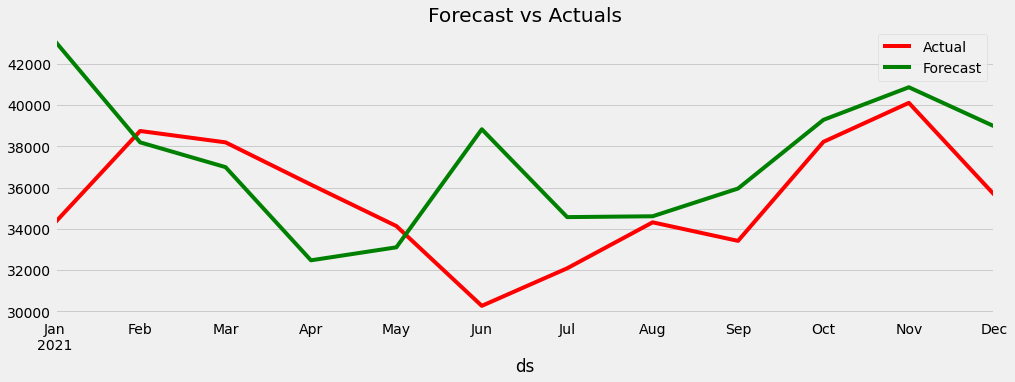

In [ ]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final_1.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [ ]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final_1['yhat']))
print('MAPE', MAPE)

MAPE 8.49207074273428


In [ ]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=ab1c8a8b12d91723b19d63c6d55f5b40ae81f6e05012b213ffcca763d289a8b7
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
from pandasql import sqldf
mysql = lambda q: sqldf(q, globals()) 
query = ''' select X_tst.ds , X_tst.y , X_tst_final_1.yhat , ABS((yhat-y)/yhat)*100 as diff
from X_tst
inner join X_tst_final_1 on X_tst.ds=X_tst_final_1.ds
group by X_tst.ds''' 
mysql(query)

,ds,y,yhat,diff
0,2021-01-01 00:00:00.000000,34289,43119.508871,20.479150
1,2021-02-01 00:00:00.000000,38746,38195.147402,1.442206
2,2021-03-01 00:00:00.000000,38195,36994.224764,3.245845
3,2021-04-01 00:00:00.000000,36145,32478.121698,11.290303
4,2021-05-01 00:00:00.000000,34139,33108.459420,3.112620
5,2021-06-01 00:00:00.000000,30271,38830.607615,22.043455
6,2021-07-01 00:00:00.000000,32092,34571.661128,7.172525
7,2021-08-01 00:00:00.000000,34319,34612.667808,0.848440
8,2021-09-01 00:00:00.000000,33420,35957.647777,7.057324
9,2021-10-01 00:00:00.000000,38221,39286.500929,2.712130


from the above, results, we can see there is significant improvement. We can further improve the model by changing the fourier order of the seasonalities and by including more features and add them as additional regressors